In [ ]:
pip install -r requirements.txt
X = pd.read_pickle("data/X.pkl")
y = pd.read_pickle("data/y.pkl")

In [105]:
pd.set_option('display.max_columns',None)
X.head(1)

,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,ALEXA_RANK,1,"10,001 or more",1001 to 10000,11 to 25,2 to 5,201 to 1000,26 to 50,51 to 200,6 to 10,date,crm_contacts_apu,crm_companies_apu,crm_deals_apu,emails_apu
0,278,0,34,0,2,0,2,0,16000001.0,False,False,False,False,True,False,False,False,False,2020-06-01,139.0,0.0,17.0,0.0


In [204]:
y = cust_actions_clean['is_customer']
X = cust_actions_clean.drop(columns=['is_customer','date'])
# Split data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

In [205]:

# Initialize and train the Lasso-penalized logistic regression model
lasso_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)
lasso_logreg.fit(X_train, y_train)


# Predict on the test set
y_pred = lasso_logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8185282522996058


In [206]:
# Print selected variables
lasso_coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": abs(lasso_logreg.coef_.flatten()) # Flatten in case it's a 2D array
})
# Method 3: Using a loop for specific columns
df_formatted_loop = lasso_coef_df.copy()
for col in df_formatted_loop.columns:
    if df_formatted_loop[col].dtype == 'float64':
        df_formatted_loop[col] = df_formatted_loop[col].apply(lambda x: f"{x:.6f}")
print("\nMethod 3:")
print(df_formatted_loop.sort_values('Coefficient'))
# Print the table
#print(lasso_coef_df.sort_values('Coefficient'))


Method 3:
                  Feature Coefficient
8              ALEXA_RANK    0.000000
0    ACTIONS_CRM_CONTACTS    0.000155
1   ACTIONS_CRM_COMPANIES    0.000217
18       crm_contacts_apu    0.001163
19      crm_companies_apu    0.002885
2       ACTIONS_CRM_DEALS    0.005202
20          crm_deals_apu    0.009090
3           ACTIONS_EMAIL    0.028807
21             emails_apu    0.114341
5     USERS_CRM_COMPANIES    0.123288
11          1001 to 10000    0.277437
4      USERS_CRM_CONTACTS    0.367143
15               26 to 50    0.378680
6         USERS_CRM_DEALS    0.400474
14            201 to 1000    0.417181
16              51 to 200    0.454631
12               11 to 25    0.467025
7             USERS_EMAIL    0.485981
13                 2 to 5    0.507706
10         10,001 or more    0.595365
17                6 to 10    0.931084
9                       1    1.803202


In [207]:
#Keep variables with coefficients > 0.1 to encourage a more sparse model
y = cust_actions_clean['is_customer']
X = cust_actions_clean.drop(columns=['is_customer','ALEXA_RANK','date','ACTIONS_CRM_CONTACTS','ACTIONS_CRM_COMPANIES',
                       'crm_contacts_apu','crm_companies_apu','ACTIONS_CRM_DEALS',
                       'crm_deals_apu','ACTIONS_EMAIL'])

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

In [209]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, n_jobs=-1)
print("Best Hyperparameters:", study.best_params)

[I 2025-03-09 21:20:41,453] A new study created in memory with name: no-name-1f486a3f-c0cb-44b2-891a-248a6233f500
[I 2025-03-09 21:20:42,899] Trial 9 finished with value: 0.696102725839153 and parameters: {'n_estimators': 75, 'max_depth': 15, 'learning_rate': 0.1537609981051204, 'subsample': 0.8950189577828017, 'colsample_bytree': 0.8333015900881541, 'gamma': 3.5865518294312535, 'reg_alpha': 5.839233996699988, 'reg_lambda': 8.805817772115459}. Best is trial 9 with value: 0.696102725839153.
[I 2025-03-09 21:20:44,363] Trial 5 finished with value: 0.6725536992840095 and parameters: {'n_estimators': 114, 'max_depth': 8, 'learning_rate': 0.014226533516252318, 'subsample': 0.6753777522602553, 'colsample_bytree': 0.7203737183021396, 'gamma': 0.3935947074586976, 'reg_alpha': 1.505855133787929, 'reg_lambda': 9.350634033891914}. Best is trial 9 with value: 0.696102725839153.
[I 2025-03-09 21:20:44,636] Trial 0 finished with value: 0.6983127109111361 and parameters: {'n_estimators': 285, 'max_de

Best Hyperparameters: {'n_estimators': 452, 'max_depth': 9, 'learning_rate': 0.04293967864841306, 'subsample': 0.5704761897312014, 'colsample_bytree': 0.9742750030767562, 'gamma': 0.8719081458526039, 'reg_alpha': 0.9312165684387766, 'reg_lambda': 2.158206184120673}


In [210]:
best_params = study.best_params
best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss")
best_model.fit(X_train, y_train)

# Evaluate the final model
y_pred_final = best_model.predict(X_test)
# Compute classification metrics
accuracy = accuracy_score(y_test, y_pred_final)
precision = precision_score(y_test, y_pred_final, average='binary')  # Change to 'macro' or 'binary' if needed
recall = recall_score(y_test, y_pred_final, average='binary')
f1 = f1_score(y_test, y_pred_final, average='binary')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Full classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))


Precision: 0.8319
Recall: 0.6319
F1 Score: 0.7182
Accuracy: 0.8357

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.88      5089
           1       0.83      0.63      0.72      2521

    accuracy                           0.84      7610
   macro avg       0.83      0.78      0.80      7610
weighted avg       0.84      0.84      0.83      7610



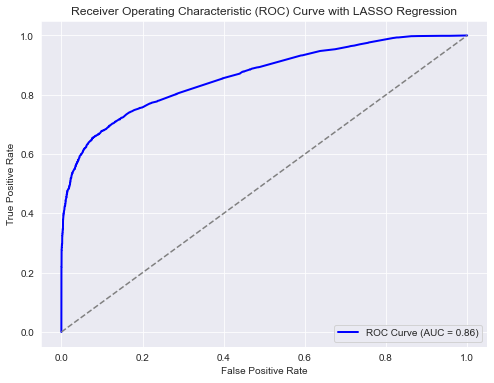

In [ ]:
# Get predicted probabilities
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with LASSO Regression')
plt.legend(loc="lower right")
plt.grid()
plt.savefig("output/my_plot29.png")


![My Plot](my_plot29.png)

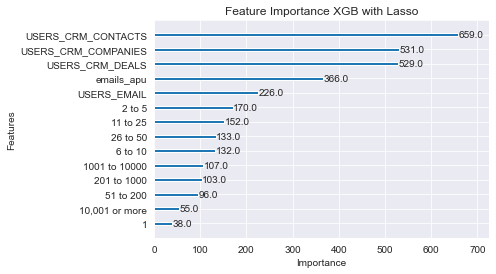

In [ ]:
# let's use built-in feature importance function
#model = XGBClassifier()
best_model.fit(X_train, y_train)
plot_importance(best_model)
plt.title("Feature Importance XGB with Lasso")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.savefig("output/my_plot22.png")  # Saves the figure
plt.show()

![My Plot](my_plot22.png)

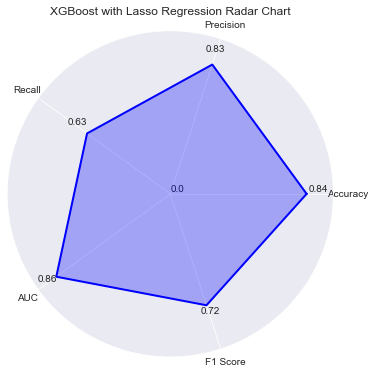

In [ ]:
# Store metrics in a dictionary
metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "AUC": roc_auc,
    "F1 Score": f1
}

# Convert dictionary to lists
labels = list(metrics.keys())
values = list(metrics.values())

# Close the radar chart by repeating the first value
values += values[:1]

# Compute angles for each axis
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # Close the plot

# Create radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot data
ax.fill(angles, values, color="blue", alpha=0.3)
ax.plot(angles, values, color="blue", linewidth=2)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

ax.set_yticks(np.arange(0, max(values) + 5, 5))
ax.set_yticklabels(np.arange(0, max(values) + 5, 5))

for angle, value in zip(angles[:-1], values[:-1]):
    ax.text(angle, value+0.07 , str(round(value,2)), ha='center', va='bottom')

# Set radial limits (optional, for better visibility)
ax.set_ylim(0, 1)

# Show the plot
plt.title("XGBoost with Lasso Regression Radar Chart")
plt.savefig("output/my_plot23.png")
plt.show()

![My Plot](my_plot23.png)

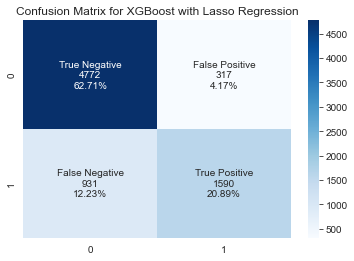

In [ ]:
# Now we set up a pipeline for future use and 
#XGboost.fit(X_train, y_train)
#y_predict = XGboost.predict(X_train)
matrix = confusion_matrix(y_test, y_pred_final)
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion Matrix for XGBoost with Lasso Regression")
plt.savefig("output/my_plot24.png")  # Saves the figure
# Our suspicion is confirmed, there are many more false negatives
# than false positives. Given more time, we might investigate why

<p style="text-align:center"> <strong>Benchmarking</strong>

<img src="my_plot12.png" width="45%"> <img src="my_plot23.png" width="45%">

As the comparison summary table below shows, the XG Boost with backward elimination outpeformed the LASSO regression on every metric. Despite the instability of backward elimination with correlated features, it is the preferable model in this case.

<img src="Comparison Summary Table.png" width="75%">

In [ ]:
best_model.to_pickle("data/best_model.pkl")
